In [1]:
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils
cudnn.benchmark = True

# some utility function for visualization
import utils
from utils.util_3d import init_mesh_renderer, sdf_to_mesh

# some utility function
from utils.qual_util import save_mesh_as_gif
from IPython.display import Image as ipy_image
from IPython.display import display

%reload_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from utils.demo_util import get_shape_comp_opt, get_imgdf_model
from utils.qual_util import load_resnet2vq_model

""" setup opt"""
gpu_id = 0
seed = 222

opt = get_shape_comp_opt(gpu_id=gpu_id, seed=seed)

opt.classifier_free=0.0
opt.guidew=0.0

""" setup models """
model = get_imgdf_model(opt, ckpt='saved_ckpt/pretrained-imgdf-chair.pth')    
model.eval()

resnet2vq = load_resnet2vq_model(opt)

""" setup renderer """
dist, elev, azim = 1.7, 20, 20
mesh_renderer = init_mesh_renderer(image_size=256, dist=dist, elev=elev, azim=azim, device=opt.device)


[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: saved_ckpt/pretrained-pvqvae.pth
[*] Model has been created: Diffusion-Model
[*] "imgdf" initialized.
[*] weight successfully load from: saved_ckpt/pretrained-imgdf-chair.pth
[*] loading state_dict with strict=False!
[*] resnet18 successfully loaded from https://download.pytorch.org/models/resnet18-f37072fd.pth.


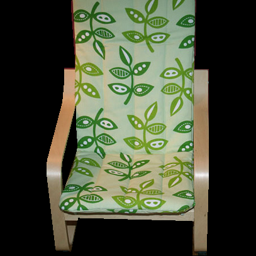

In [3]:
from utils.qual_util import preprocess_img
from PIL import Image
import torchvision.transforms as transforms

""" load preprocessed image """ 
img_path='demo_data/0001.jpg'
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
to_tensor = transforms.ToTensor()
basic_transforms = transforms.Compose([
    transforms.Normalize(mean, std),
    transforms.Resize((256, 256)),
])
img = Image.open(img_path).convert('RGB')
img_t = to_tensor(img)
img_input = basic_transforms(img_t)

res_dir = 'results/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

display(ipy_image(img_path))

/root/anaconda3/envs/3dqd/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/root/anaconda3/envs/3dqd/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/envs/3dqd/lib/python3.8/site-packages/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


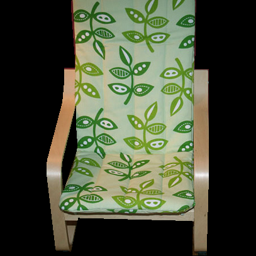

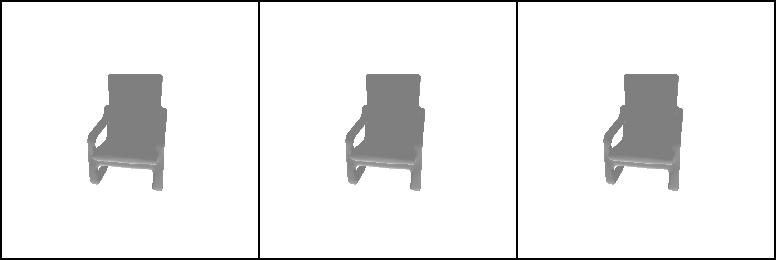

In [4]:
""" single-view reconstruction """ 
nimgs = 3

single_view_recon = model.single_view_recon(img_input.cuda(), resnet2vq, bs=nimgs)

gen_mesh = sdf_to_mesh(single_view_recon)

""" save as a gif """ 
gen_gif_name = f'{res_dir}/single-view-gen.gif'
save_mesh_as_gif(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name)

for name in [img_path, gen_gif_name]:
    display(ipy_image(name))

In [5]:
""" we provided the scripts to test on the whole pix3d dataset """ 

""" load pix3d dataset """ 
import json
def load_pix3d_info():

    with open('../dataset/pix3d/pix3d.json', 'r') as f:
        pix3d_info = json.load(f)
    # map 
    map_input_to_pix3dinfo = {}
    map_obj_to_imgs = {}

    for d in pix3d_info:
        cat = d['category']
        img_name = d['img']
        obj_file = d['model']
        model_id = obj_file.split('/')[-2]
        # img_name = os.path.splitext(img_name)[0]
        map_input_to_pix3dinfo[img_name] = d

    return pix3d_info, map_input_to_pix3dinfo

In [6]:
import glob
from tqdm import trange
""" setup pix3d img dataset and image marginal model """
from utils.qual_util import load_resnet2vq_model, preprocess_img
import numpy as np

""" select chair category """ 
all_img = glob.glob('../dataset/pix3d/img/chair/*')
mask_root ='../dataset/pix3d/mask/chair'
save_dir = 'results/'

_, map_input_to_pix3dinfo = load_pix3d_info()
for i in trange(len(all_img)):
    img_path = all_img[i]
    img_basename = os.path.basename(img_path)
    img_name_as_key = f'img/chair/{img_basename}'
    info_i = map_input_to_pix3dinfo[img_name_as_key]
    obj_file = info_i['model']
    model_id = obj_file.split('/')[-2]
    if model_id in ['IKEA_JULES_1','IKEA_MARKUS','IKEA_PATRIK','IKEA_SKRUVSTA','IKEA_SNILLE_1']:   # will be discarded
        continue
    
    img_id = img_basename.split('.')[0]
    img_mask_path = f'{mask_root}/{img_id}.png'
    

    img_input = preprocess_img(img_path, img_mask_path)

    img_name = f'{save_dir}/{img_basename}'
    vutils.save_image(img_input/2+.5, img_name)
    # display(ipy_image(img_name))
    """ single-view reconstruction """ 
    single_view_recon = model.single_view_recon(img_input.to(opt.device), resnet2vq, bs=3)
    np.save(os.path.join(save_dir, f'{img_id}.npy'), single_view_recon.cpu().numpy())
    gen_mesh = sdf_to_mesh(single_view_recon)

    # save as gif
    gen_gif_name = f'{save_dir}/{img_id}.gif'
    save_mesh_as_gif(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name, device=opt.device)

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/pix3d/pix3d.json'